In [1]:
"""
Question Answering with Pretrained Language Model
"""
# pylint:disable=redefined-outer-name,logging-format-interpolation

import os
import json
import time
import logging
import argparse
import functools
import collections
from multiprocessing import Pool, cpu_count

import mxnet as mx
import numpy as np
from mxnet.lr_scheduler import PolyScheduler

import gluonnlp.data.batchify as bf
from models import ModelForQABasic, ModelForQAConditionalV1
from eval_utils import squad_eval
from squad_utils import SquadFeature, get_squad_examples, convert_squad_example_to_feature
from gluonnlp.models import get_backbone
from gluonnlp.utils.misc import repeat, grouper, set_seed, init_comm, \
    logging_config, count_parameters, parse_ctx
from gluonnlp.initializer import TruncNorm
from gluonnlp.data.sampler import SplitSampler
from gluonnlp.utils.parameter import grad_global_norm, clip_grad_global_norm
from mxnet import np, npx
try:
    import horovod.mxnet as hvd
except ImportError:
    pass

logging.basicConfig()
logger = logging.getLogger('logger')
logger.setLevel(logging.INFO)

mx.npx.set_np()

CACHE_PATH = os.path.realpath(os.path.join(os.path.realpath('/home/wihajster/Desktop/gluon-nlp/scripts/question_answering'), '..', 'cached'))
if not os.path.exists(CACHE_PATH):
    os.makedirs(CACHE_PATH, exist_ok=True)

In [2]:
def parse_args():
    parser = argparse.ArgumentParser(
        description='Question Answering example. '
                    'We fine-tune the pretrained model on SQuAD dataset.')
    parser.add_argument('--model_name', type=str, default='google_electra_small',
                        help='Name of the pretrained model.')
    parser.add_argument('--do_train', action='store_true',
                        help='Whether to train the model')
    parser.add_argument('--do_eval', action='store_true',
                        help='Whether to evaluate the model')
    parser.add_argument('--data_dir', type=str, default='squad')
    parser.add_argument('--version', default='2.0', choices=['1.1', '2.0'],
                        help='Version of the SQuAD dataset.')
    parser.add_argument('--output_dir', type=str, default='squad_out',
                        help='The output directory where the model params will be written.'
                             ' default is squad_out')
    # Communication
    parser.add_argument('--comm_backend', type=str, default='device',
                        choices=['horovod', 'dist_sync_device', 'device'],
                        help='Communication backend.')
    parser.add_argument('--gpus', type=str, default='-1',
                        help='list of gpus to run, e.g. 0 or 0,2,5. -1 means using cpu.')
    # Training hyperparameters
    parser.add_argument('--seed', type=int, default=100, help='Random seed')
    parser.add_argument('--log_interval', type=int, default=50,
                        help='The logging interval for training')
    parser.add_argument('--eval_log_interval', type=int, default=10,
                        help='The logging interval for evaluation')
    parser.add_argument('--save_interval', type=int, default=None,
                        help='the number of steps to save model parameters.'
                             'default is every epoch')
    parser.add_argument('--epochs', type=float, default=3.0,
                        help='Number of epochs, default is 3')
    parser.add_argument('--num_train_steps', type=int, default=None,
                        help='The number of training steps. Note that epochs will be ignored '
                             'if training steps are set')
    parser.add_argument('--batch_size', type=int, default=4,
                        help='Batch size. Number of examples per gpu in a minibatch. default is 32')
    parser.add_argument('--eval_batch_size', type=int, default=4,
                        help='Evaluate batch size. Number of examples per gpu in a minibatch for '
                             'evaluation.')
    parser.add_argument('--max_grad_norm', type=float, default=1.0,
                        help='Max gradient norm.')
    parser.add_argument('--optimizer', type=str, default='adamw',
                        help='optimization algorithm. default is adamw')
    parser.add_argument('--adam_epsilon', type=float, default=1e-6,
                        help='epsilon of AdamW optimizer')
    parser.add_argument('--adam_betas', default='(0.9, 0.999)', metavar='B',
                        help='betas for Adam optimizer')
    parser.add_argument('--num_accumulated', type=int, default=1,
                        help='The number of batches for gradients accumulation to '
                             'simulate large batch size.')
    parser.add_argument('--lr', type=float, default=2e-5,
                        help='Initial learning rate. default is 2e-5')
    parser.add_argument('--warmup_ratio', type=float, default=0.1,
                        help='Ratio of warmup steps in the learning rate scheduler.')
    parser.add_argument('--warmup_steps', type=int, default=None,
                        help='warmup steps. Note that either warmup_steps or warmup_ratio is set.')
    parser.add_argument('--wd', type=float, default=0.01, help='weight decay')
    parser.add_argument('--layerwise_decay', type=float, default=-1, help='Layer-wise lr decay')
    parser.add_argument('--untunable_depth', type=float, default=-1,
                        help='Depth of untunable parameters')
    parser.add_argument('--classifier_dropout', type=float, default=0.1,
                        help='dropout of classifier')
    # Data pre/post processing
    parser.add_argument('--max_seq_length', type=int, default=512,
                        help='The maximum total input sequence length after tokenization.'
                             'Sequences longer than this will be truncated, and sequences shorter '
                             'than this will be padded. default is 512')
    parser.add_argument('--doc_stride', type=int, default=128,
                        help='When splitting up a long document into chunks, how much stride to '
                             'take between chunks. default is 128')
    parser.add_argument('--max_query_length', type=int, default=64,
                        help='The maximum number of tokens for the query. Questions longer than '
                             'this will be truncated to this length. default is 64')
    parser.add_argument('--round_to', type=int, default=None,
                        help='The length of padded sequences will be rounded up to be multiple'
                             ' of this argument. When round to is set to 8, training throughput '
                             'may increase for mixed precision training on GPUs with TensorCores.')
    parser.add_argument('--overwrite_cache', action='store_true',
                        help='Whether to overwrite the feature cache.')
    # Evaluation hyperparameters
    parser.add_argument('--start_top_n', type=int, default=5,
                        help='Number of start-position candidates')
    parser.add_argument('--end_top_n', type=int, default=5,
                        help='Number of end-position candidates corresponding '
                             'to a start position')
    parser.add_argument('--n_best_size', type=int, default=20, help='Top N results written to file')
    parser.add_argument('--max_answer_length', type=int, default=30,
                        help='The maximum length of an answer that can be generated. This is '
                             'needed because the start and end predictions are not conditioned '
                             'on one another. default is 30')
    parser.add_argument('--param_checkpoint', type=str, default=None,
                        help='The parameter checkpoint for evaluating the model')
    parser.add_argument('--backbone_path', type=str, default=None,
                        help='The parameter checkpoint of backbone model')
    parser.add_argument('--all_evaluate', action='store_true',
                        help='Whether to evaluate all intermediate checkpoints '
                             'instead of only last one')
    parser.add_argument('--max_saved_ckpt', type=int, default=5,
                        help='The maximum number of saved checkpoints')
    parser.add_argument('--eval_dtype', type=str, default='float32',
                        help='Data type used for evaluation. Either float32 or float16')
    args, unknown = parser.parse_known_args()
    return args

In [3]:
class SquadDatasetProcessor:

    def __init__(self, tokenizer, doc_stride, max_seq_length, max_query_length):
        """

        Parameters
        ----------
        tokenizer
            The tokenizer
        doc_stride
            The stride to chunk the document
        max_seq_length
            Maximum length of the merged data
        max_query_length
            Maximum query length
        """
        self._tokenizer = tokenizer
        self._doc_stride = doc_stride
        self._max_seq_length = max_seq_length
        self._max_query_length = max_query_length

        vocab = tokenizer.vocab
        self.pad_id = vocab.pad_id
        # For roberta model, taking sepecial token <s> as [CLS] and </s> as [SEP]
        self.cls_id = vocab.bos_id if 'cls_token' not in vocab.special_token_keys else vocab.cls_id
        self.sep_id = vocab.eos_id if 'sep_token' not in vocab.special_token_keys else vocab.sep_id

        # TODO(sxjscience) Consider to combine the NamedTuple and batchify functionality.
        self.ChunkFeature = collections.namedtuple('ChunkFeature',
                                              ['qas_id',
                                               'data',
                                               'valid_length',
                                               'segment_ids',
                                               'masks',
                                               'is_impossible',
                                               'gt_start',
                                               'gt_end',
                                               'context_offset',
                                               'chunk_start',
                                               'chunk_length'])
        self.BatchifyFunction = bf.NamedTuple(self.ChunkFeature,
                                         {'qas_id': bf.List(),
                                          'data': bf.Pad(val=self.pad_id),
                                          'valid_length': bf.Stack(),
                                          'segment_ids': bf.Pad(),
                                          'masks': bf.Pad(val=1),
                                          'is_impossible': bf.Stack(),
                                          'gt_start': bf.Stack(),
                                          'gt_end': bf.Stack(),
                                          'context_offset': bf.Stack(),
                                          'chunk_start': bf.Stack(),
                                          'chunk_length': bf.Stack()})

    def process_sample(self, feature: SquadFeature):
        """Process the data to the following format.

        Note that we mask all the special tokens except the CLS token. The reason for not masking
        the CLS token is that if the question is not answerable, we will set the start and end to
        be 0.


        Merged:      <CLS> Question <SEP> Context <SEP>
        Segment IDs:  0       0       0      1      1
        Mask:         0       1       1      0      1

        Here, we need to emphasize that when mask = 1, the data are actually not masked!

        Parameters
        ----------
        feature
            Tokenized SQuAD feature

        Returns
        -------
        ret
            Divide the feature into multiple chunks and extract the feature which contains
            the following:
            - data
                The data that concatenates the query and the context + special tokens
            - valid_length
                The valid_length of the data
            - segment_ids
                We assign the query part as segment 0 and the context part as segment 1.
            - masks
                We mask all the special tokens. 1 --> not masked, 0 --> masked.
            - is_impossible
                Whether the provided context is impossible to answer or not.
            - gt_start
                The ground-truth start location of the span
            - gt_end
                The ground-truth end location of the span
            - chunk_start
                The start of the chunk
            - chunk_length
                The length of the chunk
        """
        ret = []
        truncated_query_ids = feature.query_token_ids[:self._max_query_length]
        chunks = feature.get_chunks(
            doc_stride=self._doc_stride,
            max_chunk_length=self._max_seq_length - len(truncated_query_ids) - 3)
        for chunk in chunks:
            data = np.array([self.cls_id] + truncated_query_ids + [self.sep_id] +
                            feature.context_token_ids[chunk.start:(chunk.start + chunk.length)] +
                            [self.sep_id], dtype=np.int32)
            valid_length = len(data)
            segment_ids = np.array([0] + [0] * len(truncated_query_ids) +
                                   [0] + [1] * chunk.length + [1], dtype=np.int32)
            masks = np.array([0] + [1] * len(truncated_query_ids) + [1] + [0] * chunk.length + [1],
                             dtype=np.int32)
            context_offset = len(truncated_query_ids) + 2
            if chunk.gt_start_pos is None and chunk.gt_end_pos is None:
                start_pos = 0
                end_pos = 0
            else:
                # Here, we increase the start and end because we put query before context
                start_pos = chunk.gt_start_pos + context_offset
                end_pos = chunk.gt_end_pos + context_offset
            chunk_feature = self.ChunkFeature(qas_id=feature.qas_id,
                                              data=data,
                                              valid_length=valid_length,
                                              segment_ids=segment_ids,
                                              masks=masks,
                                              is_impossible=chunk.is_impossible,
                                              gt_start=start_pos,
                                              gt_end=end_pos,
                                              context_offset=context_offset,
                                              chunk_start=chunk.start,
                                              chunk_length=chunk.length)
            ret.append(chunk_feature)
        return ret

    def get_train(self, features, skip_unreliable=True):
        """Get the training dataset

        Parameters
        ----------
        features
        skip_unreliable
            Whether to skip the unreliable spans in the training set

        Returns
        -------
        train_dataset
        num_token_answer_mismatch
        num_unreliable
        """
        train_dataset = []
        num_token_answer_mismatch = 0
        num_unreliable = 0
        for feature in features:
            if feature.token_answer_mismatch:
                num_token_answer_mismatch += 1
            if feature.unreliable_span:
                num_unreliable += 1
            if skip_unreliable and feature.unreliable_span:
                # Skip when not reliable
                continue
            # Process the feature
            chunk_features = self.process_sample(feature)
            train_dataset.extend(chunk_features)
        return train_dataset, num_token_answer_mismatch, num_unreliable


def get_squad_features(args, tokenizer, segment):
    """
    Get processed data features of SQuADExampls

    Parameters
    ----------
    args : argparse.Namespace
    tokenizer:
        Tokenizer instance
    segment: str
        train or dev

    Returns
    -------
    data_features
        The list of processed data features
    """
    data_cache_path = os.path.join(CACHE_PATH,
                                   '{}_{}_squad_{}.ndjson'.format(
                                       segment, args.model_name, args.version))
    is_training = (segment == 'train')
    if os.path.exists(data_cache_path) and not args.overwrite_cache:
        data_features = []
        with open(data_cache_path, 'r') as f:
            for line in f:
                data_features.append(SquadFeature.from_json(line))
        logging.info('Found cached data features, load from {}'.format(data_cache_path))
    else:
        data_examples = get_squad_examples(args.data_dir, segment=segment, version=args.version)
        start = time.time()
        num_process = min(cpu_count(), 8)
        logging.info('Tokenize Data:')
        with Pool(num_process) as pool:
            data_features = pool.map(functools.partial(convert_squad_example_to_feature,
                                                       tokenizer=tokenizer,
                                                       is_training=is_training), data_examples)
        logging.info('Done! Time spent:{:.2f} seconds'.format(time.time() - start))
        with open(data_cache_path, 'w') as f:
            for feature in data_features:
                f.write(feature.to_json() + '\n')

    return data_features


In [4]:
def get_network(model_name,
                ctx_l,
                dropout=0.1,
                checkpoint_path=None,
                backbone_path=None,
                dtype='float32'):
    """
    Get the network that fine-tune the Question Answering Task

    Parameters
    ----------
    model_name : str
        The model name of the backbone model
    ctx_l :
        Context list of training device like [mx.gpu(0), mx.gpu(1)]
    dropout : float
        Dropout probability of the task specified layer
    checkpoint_path: str
        Path to a Fine-tuned checkpoint
    backbone_path: str
        Path to the backbone model to be loaded in qa_net

    Returns
    -------
    cfg
    tokenizer
    qa_net
    use_segmentation
    """
    # Create the network
    use_segmentation = 'roberta' not in model_name and 'xlmr' not in model_name
    Model, cfg, tokenizer, download_params_path, _ = \
        get_backbone(model_name, load_backbone=not backbone_path)
    backbone = Model.from_cfg(cfg, use_pooler=False, dtype=dtype)
    # Load local backbone parameters if backbone_path provided.
    # Otherwise, download backbone parameters from gluon zoo.

    backbone_params_path = backbone_path if backbone_path else download_params_path
    if checkpoint_path is None:
        backbone.load_parameters(backbone_params_path, ignore_extra=True,
                                 ctx=ctx_l, cast_dtype=True)
        num_params, num_fixed_params = count_parameters(backbone.collect_params())
        logging.info(
            'Loading Backbone Model from {}, with total/fixd parameters={}/{}'.format(
                backbone_params_path, num_params, num_fixed_params))
    qa_net = ModelForQAConditionalV1(backbone=backbone,
                                     dropout_prob=dropout,
                                     use_segmentation=use_segmentation,
                                     weight_initializer=TruncNorm(stdev=0.02))
    if checkpoint_path is None:
        # Ignore the UserWarning during initialization,
        # There is no need to re-initialize the parameters of backbone
        qa_net.initialize(ctx=ctx_l)
    else:
        qa_net.load_parameters(checkpoint_path, ctx=ctx_l, cast_dtype=True)
    qa_net.hybridize()

    return cfg, tokenizer, qa_net, use_segmentation


In [5]:
RawResultExtended = collections.namedtuple(
    'RawResultExtended',
    ['qas_id',
     'start_top_logits',
     'start_top_index',
     'end_top_logits',
     'end_top_index',
     'answerable_logits'])


def predict_extended(original_feature,
                     chunked_features,
                     results,
                     n_best_size,
                     max_answer_length=64,
                     start_top_n=5,
                     end_top_n=5):
    """Get prediction results for SQuAD.

    Start Logits: (B, N_start)
    End Logits: (B, N_start, N_end)

    Parameters
    ----------
    original_feature:
        The original SquadFeature before chunked
    chunked_features
        List of ChunkFeatures
    results
        List of model predictions for span start and span end.
    n_best_size
        Best N results written to file
    max_answer_length
        Maximum length of the answer tokens.
    start_top_n
        Number of start-position candidates
    end_top_n
        Number of end-position candidates
    Returns
    -------
    not_answerable_score
        Model's estimate that the question is not answerable.
    prediction
        The final prediction.
    nbest_json
        n-best predictions with their probabilities.
    """
    not_answerable_score = 1000000  # Score for not-answerable. We set it to be a large and positive
    # If one chunk votes for answerable, we will treat the context as answerable,
    # Thus, the overall not_answerable_score = min(chunk_not_answerable_score)
    all_start_idx = []
    all_end_idx = []
    all_pred_score = []
    context_length = len(original_feature.context_token_ids)
    token_max_context_score = np.full((len(chunked_features), context_length),
                                      -np.inf,
                                      dtype=np.float32)
    for i, chunked_feature in enumerate(chunked_features):
        chunk_start = chunked_feature.chunk_start
        chunk_length = chunked_feature.chunk_length
        for j in range(chunk_start, chunk_start + chunk_length):
            # This is a heuristic score
            # TODO investigate the impact
            token_max_context_score[i, j] = min(j - chunk_start,
                                                chunk_start + chunk_length - 1 - j) \
                + 0.01 * chunk_length
    token_max_chunk_id = token_max_context_score.argmax(axis=0)

    for chunk_id, (result, chunk_feature) in enumerate(zip(results, chunked_features)):
        # We use the log-likelihood as the not answerable score.
        # Thus, a high score indicates that the answer is not answerable
        cur_not_answerable_score = float(result.answerable_logits[1])
        not_answerable_score = min(not_answerable_score, cur_not_answerable_score)
        # Calculate the start_logits + end_logits as the overall score
        context_offset = chunk_feature.context_offset
        chunk_start = chunk_feature.chunk_start
        chunk_length = chunk_feature.chunk_length
        for i in range(start_top_n):
            for j in range(end_top_n):
                pred_score = result.start_top_logits[i] + result.end_top_logits[i, j]
                start_index = result.start_top_index[i]
                end_index = result.end_top_index[i, j]
                # We could hypothetically create invalid predictions, e.g., predict
                # that the start of the answer span is in the query tokens or out of
                # the chunk. We throw out all invalid predictions.
                if not (context_offset <= start_index < context_offset + chunk_length) or \
                   not (context_offset <= end_index < context_offset + chunk_length) or \
                   end_index < start_index:
                    continue
                pred_answer_length = end_index - start_index + 1
                if pred_answer_length > max_answer_length:
                    continue
                start_idx = int(start_index - context_offset + chunk_start)
                end_idx = int(end_index - context_offset + chunk_start)
                if token_max_chunk_id[start_idx] != chunk_id:
                    continue
                all_start_idx.append(start_idx)
                all_end_idx.append(end_idx)
                all_pred_score.append(pred_score)
    sorted_start_end_score = sorted(zip(all_start_idx, all_end_idx, all_pred_score),
                                    key=lambda args: args[-1], reverse=True)
    nbest = []
    context_text = original_feature.context_text
    context_token_offsets = original_feature.context_token_offsets
    seen_predictions = set()
    for start_idx, end_idx, pred_score in sorted_start_end_score:
        if len(seen_predictions) >= n_best_size:
            break
        pred_answer = context_text[context_token_offsets[start_idx][0]:
                                   context_token_offsets[end_idx][1]]
        seen_predictions.add(pred_answer)
        nbest.append((pred_answer, pred_score))

    # In very rare edge cases we could have no valid predictions. So we
    # just create a nonce prediction in this case to avoid failure.
    if len(nbest) == 0:
        nbest.append(('', float('-inf')))
    all_scores = np.array([ele[1] for ele in nbest], dtype=np.float32)
    probs = np.exp(all_scores) / np.sum(np.exp(all_scores))
    nbest_json = []
    for i, (entry, prob) in enumerate(zip(nbest, probs)):
        output = collections.OrderedDict()
        output['text'] = entry[0]
        output['probability'] = float(prob)
        nbest_json.append(output)

    assert len(nbest_json) >= 1
    return not_answerable_score, nbest[0][0], nbest_json


def evaluate(args, last=True):
    store, num_workers, rank, local_rank, is_master_node, ctx_l = init_comm(
        args.comm_backend, args.gpus)
    # only evaluate once
    if rank != 0:
        logging.info('Skipping node {}'.format(rank))
        return
    ctx_l = parse_ctx(args.gpus)
    logging.info(
        'Srarting inference without horovod on the first node on device {}'.format(
            str(ctx_l)))

    cfg, tokenizer, qa_net, use_segmentation = get_network(
        args.model_name, ctx_l, args.classifier_dropout)

    logging.info('Prepare dev data')
    dev_features = get_squad_features(args, tokenizer, segment='dev')
    dev_data_path = os.path.join(args.data_dir, 'dev-v{}.json'.format(args.version))
    dataset_processor = SquadDatasetProcessor(tokenizer=tokenizer,
                                              doc_stride=args.doc_stride,
                                              max_seq_length=args.max_seq_length,
                                              max_query_length=args.max_query_length)
    dev_all_chunk_features = []
    dev_chunk_feature_ptr = [0]
    for feature in dev_features:
        chunk_features = dataset_processor.process_sample(feature)
        dev_all_chunk_features.extend(chunk_features)
        dev_chunk_feature_ptr.append(dev_chunk_feature_ptr[-1] + len(chunk_features))

    def eval_validation(ckpt_name, best_eval):
        """
        Model inference during validation or final evaluation.
        """
        dev_dataloader = mx.gluon.data.DataLoader(
            dev_all_chunk_features,
            batchify_fn=dataset_processor.BatchifyFunction,
            batch_size=args.eval_batch_size,
            num_workers=0,
            shuffle=False)

        log_interval = args.eval_log_interval
        all_results = []
        epoch_tic = time.time()
        tic = time.time()
        epoch_size = len(dev_features)
        total_num = 0
        log_num = 0
        for batch_idx, dev_batch in enumerate(grouper(dev_dataloader, len(ctx_l))):
            # Predict for each chunk
            for sample, ctx in zip(dev_batch, ctx_l):
                if sample is None:
                    continue
                # Copy the data to device
                tokens = sample.data.as_in_ctx(ctx)
                total_num += len(tokens)
                log_num += len(tokens)
                segment_ids = sample.segment_ids.as_in_ctx(ctx) if use_segmentation else None
                valid_length = sample.valid_length.as_in_ctx(ctx)
                p_mask = sample.masks.as_in_ctx(ctx)
                p_mask = 1 - p_mask  # In the network, we use 1 --> no_mask, 0 --> mask
                start_top_logits, start_top_index, end_top_logits, end_top_index, answerable_logits \
                    = qa_net.inference(tokens, segment_ids, valid_length, p_mask,
                                       args.start_top_n, args.end_top_n)
                for i, qas_id in enumerate(sample.qas_id):
                    result = RawResultExtended(qas_id=qas_id,
                                               start_top_logits=start_top_logits[i].asnumpy(),
                                               start_top_index=start_top_index[i].asnumpy(),
                                               end_top_logits=end_top_logits[i].asnumpy(),
                                               end_top_index=end_top_index[i].asnumpy(),
                                               answerable_logits=answerable_logits[i].asnumpy())

                    all_results.append(result)

            # logging
            if (batch_idx + 1) % log_interval == 0:
                # Output the loss of per step
                toc = time.time()
                logging.info(
                    '[batch {}], Time cost={:.2f},'
                    ' Throughput={:.2f} samples/s, ETA={:.2f}h'.format(
                        batch_idx + 1, toc - tic, log_num / (toc - tic),
                        (epoch_size - total_num) / (total_num / (toc - epoch_tic)) / 3600))
                tic = time.time()
                log_num = 0

        epoch_toc = time.time()
        logging.info('Time cost=%2f s, Thoughput=%.2f samples/s', epoch_toc - epoch_tic,
                     total_num / (epoch_toc - epoch_tic))

        all_predictions = collections.OrderedDict()
        all_nbest_json = collections.OrderedDict()
        no_answer_score_json = collections.OrderedDict()
        for index, (left_index, right_index) in enumerate(zip(dev_chunk_feature_ptr[:-1],
                                                              dev_chunk_feature_ptr[1:])):
            chunked_features = dev_all_chunk_features[left_index:right_index]
            results = all_results[left_index:right_index]
            original_feature = dev_features[index]
            qas_ids = set([result.qas_id for result in results] +
                          [feature.qas_id for feature in chunked_features])
            assert len(qas_ids) == 1, 'Mismatch Occured between features and results'
            example_qas_id = list(qas_ids)[0]
            assert example_qas_id == original_feature.qas_id, \
                'Mismatch Occured between original feature and chunked features'
            not_answerable_score, best_pred, nbest_json = predict_extended(
                original_feature=original_feature,
                chunked_features=chunked_features,
                results=results,
                n_best_size=args.n_best_size,
                max_answer_length=args.max_answer_length,
                start_top_n=args.start_top_n,
                end_top_n=args.end_top_n)
            no_answer_score_json[example_qas_id] = not_answerable_score
            all_predictions[example_qas_id] = best_pred
            all_nbest_json[example_qas_id] = nbest_json

        if args.version == '2.0':
            exact = 'best_exact'
            f1 = 'best_f1'
            na_prob = no_answer_score_json
        else:
            exact = 'exact'
            f1 = 'f1'
            na_prob = None

        cur_eval, revised_predictions = squad_eval(
            dev_data_path, all_predictions, na_prob, revise=na_prob is not None)
        logging.info('The evaluated results are {}'.format(json.dumps(cur_eval)))

        cur_metrics = 0.5 * (cur_eval[exact] + cur_eval[f1])
        if best_eval:
            best_metrics = 0.5 * (best_eval[exact] + best_eval[f1])
        else:
            best_metrics = 0.

        if cur_metrics > best_metrics:
            logging.info('The evaluated files are saved in {}'.format(args.output_dir))
            output_prediction_file = os.path.join(args.output_dir, 'predictions.json')
            output_nbest_file = os.path.join(args.output_dir, 'nbest_predictions.json')
            na_prob_file = os.path.join(args.output_dir, 'na_prob.json')
            revised_prediction_file = os.path.join(args.output_dir, 'revised_predictions.json')

            with open(output_prediction_file, 'w') as of:
                of.write(json.dumps(all_predictions, indent=4) + '\n')
            with open(output_nbest_file, 'w') as of:
                of.write(json.dumps(all_nbest_json, indent=4) + '\n')
            with open(na_prob_file, 'w') as of:
                of.write(json.dumps(no_answer_score_json, indent=4) + '\n')
            with open(revised_prediction_file, 'w') as of:
                of.write(json.dumps(revised_predictions, indent=4) + '\n')

            best_eval = cur_eval
            best_eval.update({'best_ckpt': ckpt_name})
        return best_eval

    if args.param_checkpoint and args.param_checkpoint.endswith('.params'):
        ckpt_candidates = [args.param_checkpoint]
    else:
        ckpt_candidates = [f for f in os.listdir(args.output_dir) if f.endswith('.params')]
        ckpt_candidates.sort(key=lambda ele: (len(ele), ele))
    if last:
        ckpt_candidates = ckpt_candidates[-1:]

    best_eval = {}
    for ckpt_name in ckpt_candidates:
        logging.info('Starting evaluate the checkpoint {}'.format(ckpt_name))
        ckpt_path = os.path.join(args.output_dir, ckpt_name)
        qa_net.load_parameters(ckpt_path, ctx=ctx_l, cast_dtype=True)
        best_eval = eval_validation(ckpt_name, best_eval)

    logging.info('The best evaluated results are {}'.format(json.dumps(best_eval)))
    output_eval_results_file = os.path.join(args.output_dir, 'best_results.json')
    with open(output_eval_results_file, 'w') as of:
        of.write(json.dumps(best_eval, indent=4) + '\n')
    return best_eval

In [6]:
def get_model(last=True):
    args = parse_args()
    store, num_workers, rank, local_rank, is_master_node, ctx_l = init_comm(
        args.comm_backend, args.gpus)
    # only evaluate once
    if rank != 0:
        logging.info('Skipping node {}'.format(rank))
        return
    ctx_l = parse_ctx(args.gpus)
    logging.info(
        'Srarting inference without horovod on the first node on device {}'.format(
            str(ctx_l)))

    cfg, tokenizer, qa_net, use_segmentation = get_network(
        args.model_name, ctx_l, args.classifier_dropout)

    logging.info('Prepare dev data')
    dev_features = get_squad_features(args, tokenizer, segment='dev')
    dev_data_path = os.path.join(args.data_dir, 'dev-v{}.json'.format(args.version))
    dataset_processor = SquadDatasetProcessor(tokenizer=tokenizer,
                                              doc_stride=args.doc_stride,
                                              max_seq_length=args.max_seq_length,
                                              max_query_length=args.max_query_length)
    dev_all_chunk_features = []
    dev_chunk_feature_ptr = [0]
    for feature in dev_features:
        chunk_features = dataset_processor.process_sample(feature)
        dev_all_chunk_features.extend(chunk_features)
        dev_chunk_feature_ptr.append(dev_chunk_feature_ptr[-1] + len(chunk_features))
    return qa_net

### Model
Modele w gluonie są typu HybridBlock. W tym przypadku ModelForQAConditionalV1, który dziedziczy po HybridBlock

In [7]:
a = get_model()

/home/wihajster/Desktop/quantization-mxnet/python/mxnet/gluon/block.py:571: UserWarning: Parameter 'weight' is already initialized, ignoring. Set force_reinit=True to re-initialize.
  v.initialize(None, ctx, init, force_reinit=force_reinit)
/home/wihajster/Desktop/quantization-mxnet/python/mxnet/gluon/block.py:571: UserWarning: Parameter 'bias' is already initialized, ignoring. Set force_reinit=True to re-initialize.
  v.initialize(None, ctx, init, force_reinit=force_reinit)
/home/wihajster/Desktop/quantization-mxnet/python/mxnet/gluon/block.py:571: UserWarning: Parameter 'gamma' is already initialized, ignoring. Set force_reinit=True to re-initialize.
  v.initialize(None, ctx, init, force_reinit=force_reinit)
/home/wihajster/Desktop/quantization-mxnet/python/mxnet/gluon/block.py:571: UserWarning: Parameter 'beta' is already initialized, ignoring. Set force_reinit=True to re-initialize.
  v.initialize(None, ctx, init, force_reinit=force_reinit)


In [8]:
npx.set_np() # włączenie semantyki numpyowej - różni się od NDArray m.in., tym że pozwala na 0 shape np. (2,0,1)

"""
Hybrydize - samo w sobie nic nie robi od ręki - zmienia tylko pole w obiekcie, że hybrydyzacja jest aktywna.
Doperio przy pierwszym forward pass'ie wywoływana jest logika. Najpierw jest budowany cached_op - jeśli podano backend,
dokonywana jest optymalizacja za pomocą funkcji optimize_for (woła MXOptimizeForBackend w C Api) <- Prawdopodobnie
jest to Subgraph API, o którym wspomniał Xinyu w swojej prezentacji. 
Po wybduwoaniu cached_op dzieje się jakaś magia z "formatami" i dopiero jest wołany forward pass


Pytanie: Czy hybridize bez podanego backendu cokolwiek optymalizuje?

"""
from mxnet.util import use_np
from mxnet.gluon import nn, HybridBlock

@use_np
class QuantizeHybride(HybridBlock):
    def __init__(self, backbone):
        super(QuantizeHybride, self).__init__()
        self.backbone = backbone
        
    def hybrid_forward(self, F, tokens, token_types, valid_length, p_mask):
        start_top_logits, start_top_index, end_top_logits, end_top_index, answerable_logits = self.backbone.inference(F, tokens, token_types, valid_length, p_mask)
        return start_top_logits, start_top_index, end_top_logits, end_top_index, answerable_logits
    
q = QuantizeHybride(a)

#npx.set_np()
q.hybridize()

# pierwszy forward pass, który tworzy cached_op /\
q.forward(np.zeros((4, 10)), np.zeros((4, 10)), np.zeros((4,)), np.zeros((4, 10)))
mx.nd.waitall()
# export HybridBlock do JSON'a
q.export('model_a')
#wczytanie JSON'a, ale nie jako HybridBlock, tylko jako Symbol
sym, arg_params, aux_params = mx.model.load_checkpoint('model_a', 0)
## Dwa powyższe konwertują HybridBlock -> Symbol / Symbol Group

## Wizualizacja symbolu - grafu
mx.viz.plot_network(sym)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]] xd
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]] xd
[0. 0. 0. 0.] xd
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]] xd
<module 'mxnet.symbol' from '/home/wihajster/Desktop/quantization-mxnet/python/mxnet/symbol/__init__.py'>
[<_Symbol data0>, <_Symbol data1>, <_Symbol data2>, <_Symbol data3>]
[<_Symbol data0>, <_Symbol data1>, <_Symbol data2>, <_Symbol data3>] xxxxx


AssertionError: Argument data must have NDArray type, but got <_Symbol quantizehybride_where_rscalar1>

In [9]:
## Zapisanie grafu do pliku
#digraph = mx.viz.plot_network(sym,title="Electra.pdf",save_format='pdf')
#digraph.view()
#digraph.render()

#mx.viz.plot_network(q)

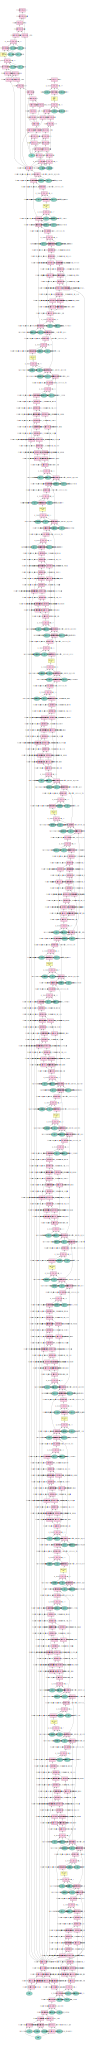

In [10]:
## Tworzenie zoptymalizowane symbolu dla danego backendu
## optymalizacja grafu
sym = sym.get_backend_symbol('MKLDNN_QUANTIZE')

## Pytanie: Czym się rózni funkcja get_backend_symbol() i optimize_for()

# (optional) visualize fused float32 model
mx.viz.plot_network(sym)



xxxxxxxx
['quantizehybride_electramodel0_dropout0_fwd_output', 'sg_mkldnn_fully_connected_0_output', 'sg_mkldnn_fully_connected_1_output', 'quantizehybride_electramodel0_electraencoder0_transformerencoderlayer0_multiheadattentioncell0_reshape0_output', 'sg_mkldnn_fully_connected_2_output', 'quantizehybride_electramodel0_electraencoder0_transformerencoderlayer0_layernorm0_layer_norm0_output', 'sg_mkldnn_fully_connected_3_output', 'quantizehybride_electramodel0_electraencoder0_transformerencoderlayer0_positionwiseffn0_dropout0_copy0_output', 'sg_mkldnn_fully_connected_4_output', 'quantizehybride_electramodel0_electraencoder0_transformerencoderlayer0_positionwiseffn0_layernorm0_layer_norm0_output', 'sg_mkldnn_fully_connected_5_output', 'quantizehybride_electramodel0_electraencoder0_transformerencoderlayer1_multiheadattentioncell0_reshape0_output', 'sg_mkldnn_fully_connected_6_output', 'quantizehybride_electramodel0_electraencoder0_transformerencoderlayer1_layernorm0_layer_norm0_output',

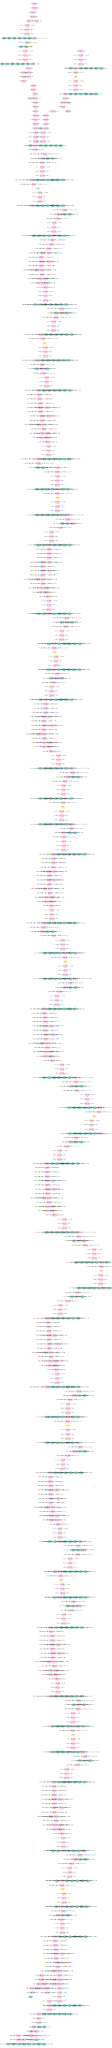

In [11]:
# quantize configs
# set exclude layers

from mxnet.contrib.quantization import *
excluded_names = []
# set calib mode.
calib_mode = 'entropy'
# set quantized_dtype
quantized_dtype = 'auto'
qsym, qarg_params, aux_params, collector = quantize_graph(sym=sym, arg_params=arg_params, aux_params=aux_params,
                                                          excluded_sym_names=excluded_names,
                                                          calib_mode=calib_mode, quantize_mode='full',
                                                          quantized_dtype=quantized_dtype)
# save quantized model
mx.model.save_checkpoint('quantized-relectra', 0, qsym, qarg_params, aux_params)
mx.viz.plot_network(qsym)

In [12]:

args = parse_args()
store, num_workers, rank, local_rank, is_master_node, ctx_l = init_comm(
    args.comm_backend, args.gpus)

ctx_l = parse_ctx(args.gpus)

print(collector.collect)

cfg, tokenizer, qa_net, use_segmentation = get_network(
    args.model_name, ctx_l, args.classifier_dropout)

qa_net.register_op_hook(collector.collect, monitor_all=True) # sym._simple_bind(ctx=cpu())
#exe.copy_params_from(arg_params = arg_params, aux_params = aux_params)
#exe._register_op_hook(collector.collect, monitor_all=True)
#exe.set_monitor_callback(collector.collect, monitor_all=True)
print(type(qa_net))
dev_features = get_squad_features(args, tokenizer, segment='dev')
dev_data_path = os.path.join(args.data_dir, 'dev-v{}.json'.format(args.version))
dataset_processor = SquadDatasetProcessor(tokenizer=tokenizer,
                                          doc_stride=args.doc_stride,
                                          max_seq_length=args.max_seq_length,
                                          max_query_length=args.max_query_length)
dev_all_chunk_features = []
dev_chunk_feature_ptr = [0]
for feature in dev_features:
    chunk_features = dataset_processor.process_sample(feature)
    dev_all_chunk_features.extend(chunk_features)
    dev_chunk_feature_ptr.append(dev_chunk_feature_ptr[-1] + len(chunk_features))

    def eval_validation():
        """
        Model inference during validation or final evaluation.
        """
        dev_dataloader = mx.gluon.data.DataLoader(
            dev_all_chunk_features,
            batchify_fn=dataset_processor.BatchifyFunction,
            batch_size=args.eval_batch_size,
            num_workers=0,
            shuffle=False)

        log_interval = args.eval_log_interval
        all_results = []
        epoch_tic = time.time()
        tic = time.time()
        epoch_size = len(dev_features)
        total_num = 0
        log_num = 0
        for batch_idx, dev_batch in enumerate(grouper(dev_dataloader, len(ctx_l))):
            # Predict for each chunk
            for sample, ctx in zip(dev_batch, ctx_l):
                if sample is None:
                    continue
                # Copy the data to device
                tokens = sample.data.as_in_ctx(ctx)
                total_num += len(tokens)
                log_num += len(tokens)
                segment_ids = sample.segment_ids.as_in_ctx(ctx) if use_segmentation else None
                gt_start = sample.gt_start.as_in_ctx(ctx).astype(np.int32)
                valid_length = sample.valid_length.as_in_ctx(ctx)
                p_mask = sample.masks.as_in_ctx(ctx)
                p_mask = 1 - p_mask  # In the network, we use 1 --> no_mask, 0 --> mask
                start_logits, end_logits, answerable_logits \
                    = qa_net(tokens, segment_ids, valid_length, p_mask, gt_start)
            break

eval_validation()

<bound method _LayerHistogramCollector.collect of <mxnet.contrib.quantization._LayerHistogramCollector object at 0x7fa4fa3efa90>>


/home/wihajster/Desktop/quantization-mxnet/python/mxnet/gluon/block.py:571: UserWarning: Parameter 'weight' is already initialized, ignoring. Set force_reinit=True to re-initialize.
  v.initialize(None, ctx, init, force_reinit=force_reinit)
/home/wihajster/Desktop/quantization-mxnet/python/mxnet/gluon/block.py:571: UserWarning: Parameter 'bias' is already initialized, ignoring. Set force_reinit=True to re-initialize.
  v.initialize(None, ctx, init, force_reinit=force_reinit)
/home/wihajster/Desktop/quantization-mxnet/python/mxnet/gluon/block.py:571: UserWarning: Parameter 'gamma' is already initialized, ignoring. Set force_reinit=True to re-initialize.
  v.initialize(None, ctx, init, force_reinit=force_reinit)
/home/wihajster/Desktop/quantization-mxnet/python/mxnet/gluon/block.py:571: UserWarning: Parameter 'beta' is already initialized, ignoring. Set force_reinit=True to re-initialize.
  v.initialize(None, ctx, init, force_reinit=force_reinit)


<class 'models.ModelForQAConditionalV1'>
[[  101  1999  2054  2406  2003 13298  2284  1029   102  1996  5879  2015
   1006  5879  1024  2053  3126  2386  5104  1025  2413  1024  5879  5104
   1025  3763  1024  5879  3490  1007  2020  1996  2111  2040  1999  1996
   6049  1998  6252  4693  2435  2037  2171  2000 13298  1010  1037  2555
   1999  2605  1012  2027  2020  9287  2013 15342  1006  1000  5879  1000
   3310  2013  1000 15342  2386  1000  1007 10642  1998  8350  2013  5842
   1010 10399  1998  5120  2040  1010  2104  2037  3003  4897  2080  1010
   3530  2000  8415 10768  2389  3723  2000  2332  2798  3523  1997  2225
  23151  7405  1012  2083  8213  1997 27574  1998  6809  2007  1996  3128
  26165  1998  3142  1011 26522  4509  7080  1010  2037  8481  2052  6360
  13590  2007  1996  8594  2075  2937  1011  2241  8578  1997  2225 23151
   7405  1012  1996  5664  3451  1998  5636  4767  1997  1996  5879  2015
   6003  3322  1999  1996  2034  2431  1997  1996  6049  2301  1010  19

In [19]:
cqsym, cqarg_params, aux_params = calib_graph(qsym=qsym, arg_params=arg_params, aux_params=aux_params,
                                            collector=collector, calib_mode=calib_mode,
                                            quantized_dtype=quantized_dtype, logger=logger)

INFO:logger:Calculating optimal thresholds for quantization
INFO:logger:Calculating optimal thresholds for quantization using KL divergence with num_quantized_bins=255
INFO:logger:Quantizing parameters


{}


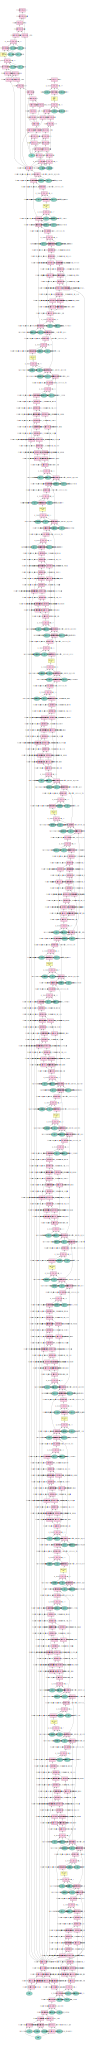

In [14]:
mx.viz.plot_network(cqsym)

In [20]:

mx.model.save_checkpoint('calibrated', 0, cqsym, cqarg_params, aux_params)

In [16]:
def evaluate(model, last=True):
    args = parse_args()
    store, num_workers, rank, local_rank, is_master_node, ctx_l = init_comm(
        args.comm_backend, args.gpus)
    ctx_l = parse_ctx(args.gpus)
    logging.info(
        'Srarting inference without horovod on the first node on device {}'.format(
            str(ctx_l)))

    cfg, tokenizer, qa_net, use_segmentation = get_network(
        args.model_name, ctx_l, args.classifier_dropout)

    dev_features = get_squad_features(args, tokenizer, segment='dev')
    dev_data_path = os.path.join(args.data_dir, 'dev-v{}.json'.format(args.version))
    dataset_processor = SquadDatasetProcessor(tokenizer=tokenizer,
                                              doc_stride=args.doc_stride,
                                              max_seq_length=args.max_seq_length,
                                              max_query_length=args.max_query_length)
    dev_all_chunk_features = []
    dev_chunk_feature_ptr = [0]
    for feature in dev_features:
        chunk_features = dataset_processor.process_sample(feature)
        dev_all_chunk_features.extend(chunk_features)
        dev_chunk_feature_ptr.append(dev_chunk_feature_ptr[-1] + len(chunk_features))

    def eval_validation():
        """
        Model inference during validation or final evaluation.
        """
        best_eval = None
        dev_dataloader = mx.gluon.data.DataLoader(
            dev_all_chunk_features,
            batchify_fn=dataset_processor.BatchifyFunction,
            batch_size=args.eval_batch_size,
            num_workers=0,
            shuffle=False)

        log_interval = args.eval_log_interval
        all_results = []
        epoch_tic = time.time()
        tic = time.time()
        epoch_size = len(dev_features)
        total_num = 0
        log_num = 0
        for batch_idx, dev_batch in enumerate(grouper(dev_dataloader, len(ctx_l))):
            # Predict for each chunk
            for sample, ctx in zip(dev_batch, ctx_l):
                if sample is None:
                    continue
                # Copy the data to device
                tokens = sample.data.as_in_ctx(ctx)
                total_num += len(tokens)
                log_num += len(tokens)
                segment_ids = sample.segment_ids.as_in_ctx(ctx) if use_segmentation else None
                
                gt_start = sample.gt_start.as_in_ctx(ctx).astype(np.int32)
                valid_length = sample.valid_length.as_in_ctx(ctx)
                p_mask = sample.masks.as_in_ctx(ctx)
                p_mask = 1 - p_mask  # In the network, we use 1 --> no_mask, 0 --> mask
                gt_start = sample.gt_start.as_in_ctx(ctx).astype(np.int32)
                
                start_top_logits, start_top_index, end_top_logits, end_top_index, answerable_logits \
                    = model(tokens, segment_ids, valid_length, p_mask)
                    
        
                for i, qas_id in enumerate(sample.qas_id):
                    result = RawResultExtended(qas_id=qas_id,
                                               start_top_logits=start_top_logits[i].asnumpy(),
                                               start_top_index=start_top_index[i].asnumpy(),
                                               end_top_logits=end_top_logits[i].asnumpy(),
                                               end_top_index=end_top_index[i].asnumpy(),
                                               answerable_logits=answerable_logits[i].asnumpy())

                    all_results.append(result)


            # logging
            if (batch_idx + 1) % log_interval == 0:
                # Output the loss of per step
                toc = time.time()
                logging.info(
                    '[batch {}], Time cost={:.2f},'
                    ' Throughput={:.2f} samples/s, ETA={:.2f}h'.format(
                        batch_idx + 1, toc - tic, log_num / (toc - tic),
                        (epoch_size - total_num) / (total_num / (toc - epoch_tic)) / 3600))
                tic = time.time()
                log_num = 0

        epoch_toc = time.time()
        logging.info('Time cost=%2f s, Thoughput=%.2f samples/s', epoch_toc - epoch_tic,
                     total_num / (epoch_toc - epoch_tic))

        all_predictions = collections.OrderedDict()
        all_nbest_json = collections.OrderedDict()
        no_answer_score_json = collections.OrderedDict()
        for index, (left_index, right_index) in enumerate(zip(dev_chunk_feature_ptr[:-1],
                                                              dev_chunk_feature_ptr[1:])):
            chunked_features = dev_all_chunk_features[left_index:right_index]
            results = all_results[left_index:right_index]
            original_feature = dev_features[index]
            qas_ids = set([result.qas_id for result in results] +
                          [feature.qas_id for feature in chunked_features])
            assert len(qas_ids) == 1, 'Mismatch Occured between features and results'
            example_qas_id = list(qas_ids)[0]
            assert example_qas_id == original_feature.qas_id, \
                'Mismatch Occured between original feature and chunked features'
            not_answerable_score, best_pred, nbest_json = predict_extended(
                original_feature=original_feature,
                chunked_features=chunked_features,
                results=results,
                n_best_size=args.n_best_size,
                max_answer_length=args.max_answer_length,
                start_top_n=args.start_top_n,
                end_top_n=args.end_top_n)
            no_answer_score_json[example_qas_id] = not_answerable_score
            all_predictions[example_qas_id] = best_pred
            all_nbest_json[example_qas_id] = nbest_json

        if args.version == '2.0':
            exact = 'best_exact'
            f1 = 'best_f1'
            na_prob = no_answer_score_json
        else:
            exact = 'exact'
            f1 = 'f1'
            na_prob = None

        cur_eval, revised_predictions = squad_eval(
            dev_data_path, all_predictions, na_prob, revise=na_prob is not None)
        logging.info('The evaluated results are {}'.format(json.dumps(cur_eval)))

        cur_metrics = 0.5 * (cur_eval[exact] + cur_eval[f1])
        if best_eval:
            best_metrics = 0.5 * (best_eval[exact] + best_eval[f1])
        else:
            best_metrics = 0.

        if cur_metrics > best_metrics:
            logging.info('The evaluated files are saved in {}'.format(args.output_dir))
            output_prediction_file = os.path.join(args.output_dir, 'predictions.json')
            output_nbest_file = os.path.join(args.output_dir, 'nbest_predictions.json')
            na_prob_file = os.path.join(args.output_dir, 'na_prob.json')
            revised_prediction_file = os.path.join(args.output_dir, 'revised_predictions.json')

            with open(output_prediction_file, 'w') as of:
                of.write(json.dumps(all_predictions, indent=4) + '\n')
            with open(output_nbest_file, 'w') as of:
                of.write(json.dumps(all_nbest_json, indent=4) + '\n')
            with open(na_prob_file, 'w') as of:
                of.write(json.dumps(no_answer_score_json, indent=4) + '\n')
            with open(revised_prediction_file, 'w') as of:
                of.write(json.dumps(revised_predictions, indent=4) + '\n')
            ckpt_name = "xd"
            best_eval = cur_eval
            best_eval.update({'best_ckpt': ckpt_name})
        return best_eval


    best_eval_x = eval_validation()

    logging.info('The best evaluated results are {}'.format(json.dumps(best_eval_x)))
    output_eval_results_file = os.path.join(args.output_dir, 'best_results.json')
    with open(output_eval_results_file, 'w') as of:
        of.write(json.dumps(best_eval_x, indent=4) + '\n')
    return best_eval_x

In [17]:
netxx = mx.gluon.SymbolBlock.imports('model_a-symbol.json', ['data0', 'data1', 'data2', 'data3'], 'model_a-0000.params')
netxx.hybridize(static_shape=True, static_alloc=True)

res = evaluate(netxx)
print(res)

/home/wihajster/Desktop/quantization-mxnet/python/mxnet/gluon/block.py:1727: UserWarning: Cannot decide type for the following arguments. Consider providing them as input:
	data0: None
  input_sym_arg_type = in_param.infer_type()[0]
/home/wihajster/Desktop/quantization-mxnet/python/mxnet/gluon/block.py:571: UserWarning: Parameter 'weight' is already initialized, ignoring. Set force_reinit=True to re-initialize.
  v.initialize(None, ctx, init, force_reinit=force_reinit)
/home/wihajster/Desktop/quantization-mxnet/python/mxnet/gluon/block.py:571: UserWarning: Parameter 'bias' is already initialized, ignoring. Set force_reinit=True to re-initialize.
  v.initialize(None, ctx, init, force_reinit=force_reinit)
/home/wihajster/Desktop/quantization-mxnet/python/mxnet/gluon/block.py:571: UserWarning: Parameter 'gamma' is already initialized, ignoring. Set force_reinit=True to re-initialize.
  v.initialize(None, ctx, init, force_reinit=force_reinit)
/home/wihajster/Desktop/quantization-mxnet/pyth

OrderedDict([('exact', 2.8131053651141245), ('f1', 6.355635449414382), ('total', 11873), ('HasAns_exact', 0.16869095816464239), ('HasAns_f1', 7.263910204267407), ('HasAns_total', 5928), ('NoAns_exact', 5.44995794785534), ('NoAns_f1', 5.44995794785534), ('NoAns_total', 5945), ('best_exact', 50.07159100480081), ('best_exact_thresh', 0.0), ('best_f1', 50.07159100480081), ('best_f1_thresh', 0.0), ('best_ckpt', 'xd')])


In [21]:
quantized_net = mx.gluon.SymbolBlock.imports('calibrated-symbol.json', ['data0', 'data1', 'data2', 'data3'], 'calibrated-0000.params')
quantized_net.hybridize(static_shape=True, static_alloc=True)
evaluate(quantized_net)

<ipython-input-5-6b4ea11cae1b>:119: RuntimeWarning: invalid value encountered in true_divide
  probs = np.exp(all_scores) / np.sum(np.exp(all_scores))


OrderedDict([('exact', 2.720458182430725),
             ('f1', 6.360712410172853),
             ('total', 11873),
             ('HasAns_exact', 0.10121457489878542),
             ('HasAns_f1', 7.392162355935003),
             ('HasAns_total', 5928),
             ('NoAns_exact', 5.332211942809083),
             ('NoAns_f1', 5.332211942809083),
             ('NoAns_total', 5945),
             ('best_exact', 50.07159100480081),
             ('best_exact_thresh', 0.0),
             ('best_f1', 50.07159100480081),
             ('best_f1_thresh', 0.0),
             ('best_ckpt', 'xd')])